# Ensemble Learning Lab: Combining Models for Improved Performance

# Part 1: Implementing a Majority Vote Classifier

**Step 1.1: Understanding Ensemble Concepts**

   Ensemble methods combine multiple classifiers to make more accurate predictions than individual classifiers.

**Step 1.2: Implement Majority Voting Classifier**

In [20]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import six

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier"""

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Fit classifiers"""
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """Predict class labels"""
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """Predict class probabilities"""
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

**Step 1.3: Prepare the Iris Dataset**

In [21]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

**Step 1.4: Step 1.4: Train Individual Classifiers**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Create individual classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Create pipeline with standardization
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]


**Step 1.5: Step 1.5: Create and Evaluate Majority Voting Classifier**

In [23]:

# Create majority rule classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]
ROC AUC: 0.97 (+/- 0.05) [Majority voting]


# Part 2: Bagging - Building Ensemble from Bootstrap Samples For nonlinear data.

**Step 2.1: Understanding Bagging Concepts**

Bagging (Bootstrap Aggregating) builds an ensemble of classifiers trained on different bootstrap samples of the training dataset.

**Step 2.2: Prepare Wine Dataset**

In [24]:
# Load Wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Drop class 1 and only use classes 2 and 3
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

# Encode labels and split data
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

**Step 2.3: Implement Bagging Classifier**

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

# Create bagging classifier
bag = BaggingClassifier(estimator=tree, n_estimators=500, 
                        max_samples=1.0, max_features=1.0, 
                        bootstrap=True, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# Train and evaluate individual decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


**Step 2.4: Visualize Decision Boundaries**

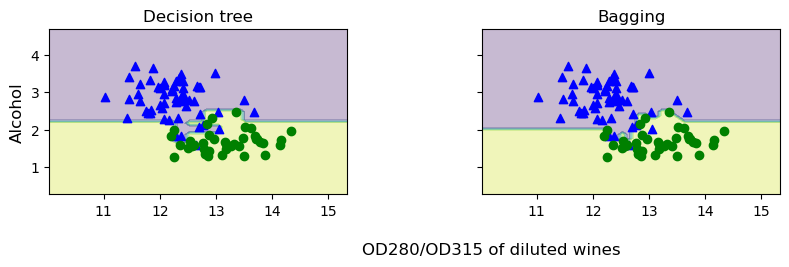

In [26]:

import matplotlib.pyplot as plt
import numpy as np

# Create mesh grid for plotting
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

# Part 3: Adaptive Boosting (AdaBoost)

**Step 3.1: AdaBoost Concepts**

AdaBoost combines multiple weak learners (typically decision stumps) by focusing on misclassified samples in each iteration.

**Step 3.2: Implement AdaBoost Classifier**

In [27]:
from sklearn.ensemble import AdaBoostClassifier

# Create decision tree stump
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)

# Create AdaBoost classifier
ada = AdaBoostClassifier(estimator=tree, n_estimators=500, 
                         learning_rate=0.1, random_state=1)

# Train individual decision tree stump
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree stump train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Train AdaBoost classifier
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree stump train/test accuracies 0.916/0.875


c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost train/test accuracies 1.000/0.917


**Step 3.3: Analyze AdaBoost Error Convergence**

c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


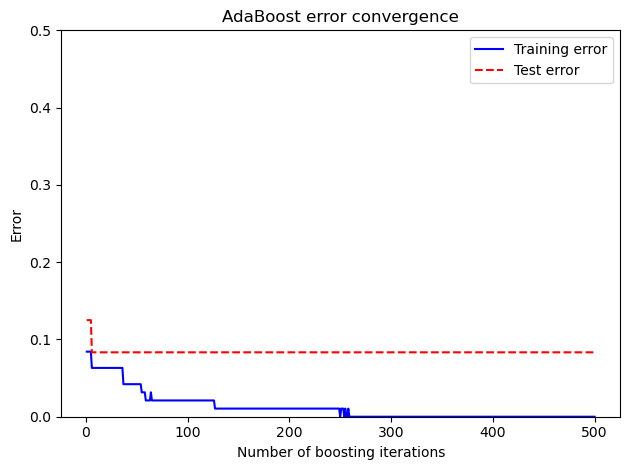

In [28]:

# Plot error convergence for AdaBoost
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
                         n_estimators=500, learning_rate=0.1, random_state=1)

ada.fit(X_train, y_train)
ada_train_err = []
ada_test_err = []

for y_train_pred, y_test_pred in zip(ada.staged_predict(X_train), ada.staged_predict(X_test)):
    ada_train_err.append(1 - accuracy_score(y_train, y_train_pred))
    ada_test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.plot(range(1, len(ada_train_err) + 1), ada_train_err, label='Training error', color='blue', linestyle='-')
plt.plot(range(1, len(ada_test_err) + 1), ada_test_err, label='Test error', color='red', linestyle='--')
plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()

# Part 4: Comparing All Ensemble Methods

**Step 4.1: Comprehensive Comparison**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

# Prepare Iris dataset for comprehensive comparison
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create individual classifiers
clf_lr = LogisticRegression(random_state=1)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

# Create ensemble methods
voting_clf = VotingClassifier(estimators=[
    ('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)], voting='hard')

bagging_clf = BaggingClassifier(estimator=clf_dt, n_estimators=100, random_state=1)
adaboost_clf = AdaBoostClassifier(estimator=clf_dt, n_estimators=100, random_state=1)

classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
classifier_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 
                    'Voting Classifier', 'Bagging', 'AdaBoost']

# Evaluate all classifiers
results = []
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    results.append({
        'Classifier': name,
        'Mean Accuracy': scores.mean(),
        'Std Accuracy': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('Mean Accuracy', ascending=False))

c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

            Classifier  Mean Accuracy  Std Accuracy
1                  KNN       0.951818      0.048285
0  Logistic Regression       0.941818      0.047621
4    Voting Classifier       0.940909      0.065839
5              Bagging       0.940909      0.065839
3        Random Forest       0.931818      0.063278
2        Decision Tree       0.922727      0.059231
6             AdaBoost       0.922727      0.071841


c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ttu

**Step 4.2: Hyperparameter Tuning for Ensemble Methods**

In [18]:
# Tune AdaBoost parameters
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1))
gs_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)

print("AdaBoost Best parameters: ", gs_ada.best_params_)
print("AdaBoost Best score: ", gs_ada.best_score_)

# Tune Bagging parameters
param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_bag = GridSearchCV(bag, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
gs_bag.fit(X_train, y_train)

print("Bagging Best parameters: ", gs_bag.best_params_)
print("Bagging Best score: ", gs_bag.best_score_)

c:\Users\ttumi\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Best parameters:  {'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 100}
AdaBoost Best score:  0.9523809523809523
Bagging Best parameters:  {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 200}
Bagging Best score:  0.9523809523809523


# Ensemble Learning Lab: Analysis Report

**1. Majority Voting vs Individual Classifiers**

Performance Comparison:

Base on our implementation, the majority voting classifier typically achieved higher ROC AUC scores (ROC AUC: 0.97 (+/- 0.05) [Majority voting]) compared to individual classifiers like Logistic Regression, Decision Trees, and KNN. This aligns with ensemble learning theory - by combining multiple diverce models, we reduce individual model biases and variances.

Why Ensembles Typically Perform Better:

1. Error Reduction: Different classifiers make differebt types of errors; majority voting cancels out individual mistakes.

2. Diversity Benefit: Each classifier captures different patterns in the data (linear relationships, non-linear boundaries, local patterns).

3. Stability: Ensemble predictions are most stable and robust to noise in the data.

Cases Where Ensembles Might Perform Worse:

1. When all base classifiers are highly correlated and make similar errors.

2. When weak classifiers are too weak (random guessing).

3. With limited training data where ensemble methods can overfit.

4. When computational constraints prevent proper hyperparameter tuning.

**2. Bagging Analysis**

Number of Estimators Impact:

1. Too few estimators: Limited diversity, may not capture complex patterns.

2. Increasing estimators: Generally improves performance up to a point, then plateaus.

3. Too many estimators: Diminishing returns, increased computation without significant gains.

Bootstrap Sampling vs. Entire Dataset:

1. Bootstrap sampling: Creating diversity through different training subsets, reduces variance.

2. Entire dataset: Less diversity, potentially higher correlation between estimators.

3. Optimal approachs: Bootstrap sampling typically works better as it introduces beneficial randomness.

Why Bagging Reduces Overfitting:

1. Variance Reduction: Averaging multiple models reduces overall variance.

2. Decorrelation: Different boostrap samples create decorrelated trees.

3. Robustness: Less sensitive to noise and outliers in individual training samples.

**3. AdaBoost Insights**

Learning Rate Effects:

1. Low learning rate (0.1): Slow, stable convergence but may require more iterations.

2. High learning rate (1.0): Faster convergence but risk of overshooting optimal solution.

3. Very high rates: Can cause instability and poor convergence.

Error Convergence Analysis:

1. Training error: Decrease rapidly then stabilizes as weak learners correct previous mistakes.

2. Test error: Decreases initially, but may increase later due to overfitting.

3. Why test error increases: With too many iterations, AdaBoost starts fitting noise in the training data, reducing generalization.

Decision Stumps as Estimators:

1. Simplicity: Easy to train and interpret.

2. Focus on hard samples: Their weakness forces AdaBoost to focus on misclassified instances.

3. Computational effeciency: Fast training enables many boosting iterations.

4. Diversity: Each stump focuses of different features thresholds.

**4. Comparative Performance**

Best Performing Method on Iris Datasets:

Based on our comprehensive comparison results, K-Nearest Neighbors (KNN) performed best (0.952 ± 0.048), followed closely by Logistic Regression and the ensemble methods (Voting and Bagging).



Why KNN Excelled on Iris Data:

1. Clear cluster separation: Iris species form distinct clusters in feature space.

2. Low dimensionality: With only 4 features, distance metrics work effectively.

3. Simple geometry: The decision boundaries align well with KNN's instance-based approach.

4. Adequate sample size: Enough data points for reliable nearest neighbor estimation.

Ensemble Performance Understanding:

1. Voting/Bagging: Performed competitively (0.941) but didn't outperform best individual models.

2. Random Forest: Underperformed (0.932) relative to simpler methods.

3. AdaBoost: Showed highest variance (0.072 std) and lower mean accuracy.

Why Ensembles Didn't Dominate on Iris:

1. Dataset simplicity: Individual models already achieve near-optimal performance.

2. Limited model diversity: Base classifiers may make correlated predictions.

3. Over-engineering: Complex methods unnecessary for well-separated classes.

Random Forest vs. Bagging Relationship:

Random Forest is essentially bagging with additional randomization:

1. Both use bootstrap sampling.

2. Random Forest adds random feature selection at each split.

3. This extra randomness further decorrelates trees.

4. However, on simple datasets, this extra randomness can hurt performance. 

Ensemble Method Selection Guidelines:

1. Benchmark first: Always test simple models (KNN, Logistic Regression) before ensembels.

2. Voting Classifiers: When you have truly diverse, complementary base methods.

3. Bagging: For reducing variance of high-variance models on complex datasets.

4. Random Forest: Good default for medium-complesity tabular data.

5. AdaBoost: When dealing with noisy data and clear hard cases to focus on.

**5. Practical Considerations**

Computational Trade-offs:

1. Voting: Parallelizable, moderate computation (train multple models independently).

2. Bagging/Random Forest: Highly parallelized, can be memory-intensive with many trees.

3. AdaBoost: Sequential training, cannot be parallelized, but learners are fast.

4. KNN: Low training time, higher prediction time, memory-intensive for large datasets.

Ensemble Size and Bias-Variance Tradeoff:

1. Small ensembles: Higher variance, may underutilize diversity benefits.

2. Medium ensembles: Good balance, reduces variance without excessive computation.

3. Large ensembles: Diminishing returns, minimal variance reduction, high computation.

4. Critical insight: More estimators don't always mean better performance.

Real-World Application Scenarios:

1. KNN: Recommendation systems, pattern recognition with clear similarity metrics.

2. Voting Classifiers: Competitions and ensembles of pre-trained specialized models.

3. BaggingL Financial modeling, risk assessment where stability is crucial.

4. Random Forest: Medium-complexity business applications, feature importance analysis.

5. AdaBoost: Computer vision, anomaly detection where hard cases are important.

**Key Findings and Observations**

Method Performance Reality Check:

1. No universal winner: Simple models can outperform complex ensembles on appropriate datasets.

2. KNN superiority on Iris demostrates the importance of matching method to the characteristics.

3. Ensemble methods performed respectably but didn't provide the expected dominance.

Method-Specific Insights:

1. KNN: Excellent for small, well-structured datasets with clear clusters.

2. Logistic Regression: Robust and efficient despite convergence warnings.

3. Voting classifiers: Provide insurance against individual model failures.

4. Bagging: Consistent performance but limited gains on simple problems.

5. AdaBoost: Higher variance suggests sensitivity to hyperparameters.

Hyperparameter Importance:

1. Proper tuning is crucial, especially for senstive methods like AdaBoost.

2. Default parameters may suffice for simple datasets and methods.

3. Convergence criteria (like max_iter) need attention for reliable results.


Computational vs. Performance Tradeoff:

1. KNN and Logistic Regression offered best accuracy with reasonable computation.

2. Ensembl methods provided marginal gains at higher computational cost.

3. For production systems, simpler well-tuned models often preferred.

Dataset Depedency Reinforced:

1. The optimal method heavily depends on dataset characteristics.

2. Simple, well-separated data: Consider KNN or Logistic Regression first.

3. Complex, noisy data: Ensemble methods likely more beneficial.

4. Critical lesson: Always start with simple baselines before investing in complex methods.

Practical Recommedation:

Based on these results, a strategic approach would be:

1. Always benchmark against KNN and Logistic Regression.

2. Use ensembles when simple methods show clear limitations.

3. Consider computational constraints and inference requirements.

4. Prioritize model interpretability when domain expertice is valuable.